In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "animal_skin_data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2016 files belonging to 4 classes.


In [7]:
class_names = dataset.class_names
class_names

['Fungal infection skin diseased dog',
 'Healthy cattle',
 'Healthy dog',
 'Lumpy skin diseased cattle']

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 2 1 2 1 2 3 2 0 1 0 1 2 2 2 0 1 1 2 2 0 0 3 0 3 3 3 0 0 0 1 3]


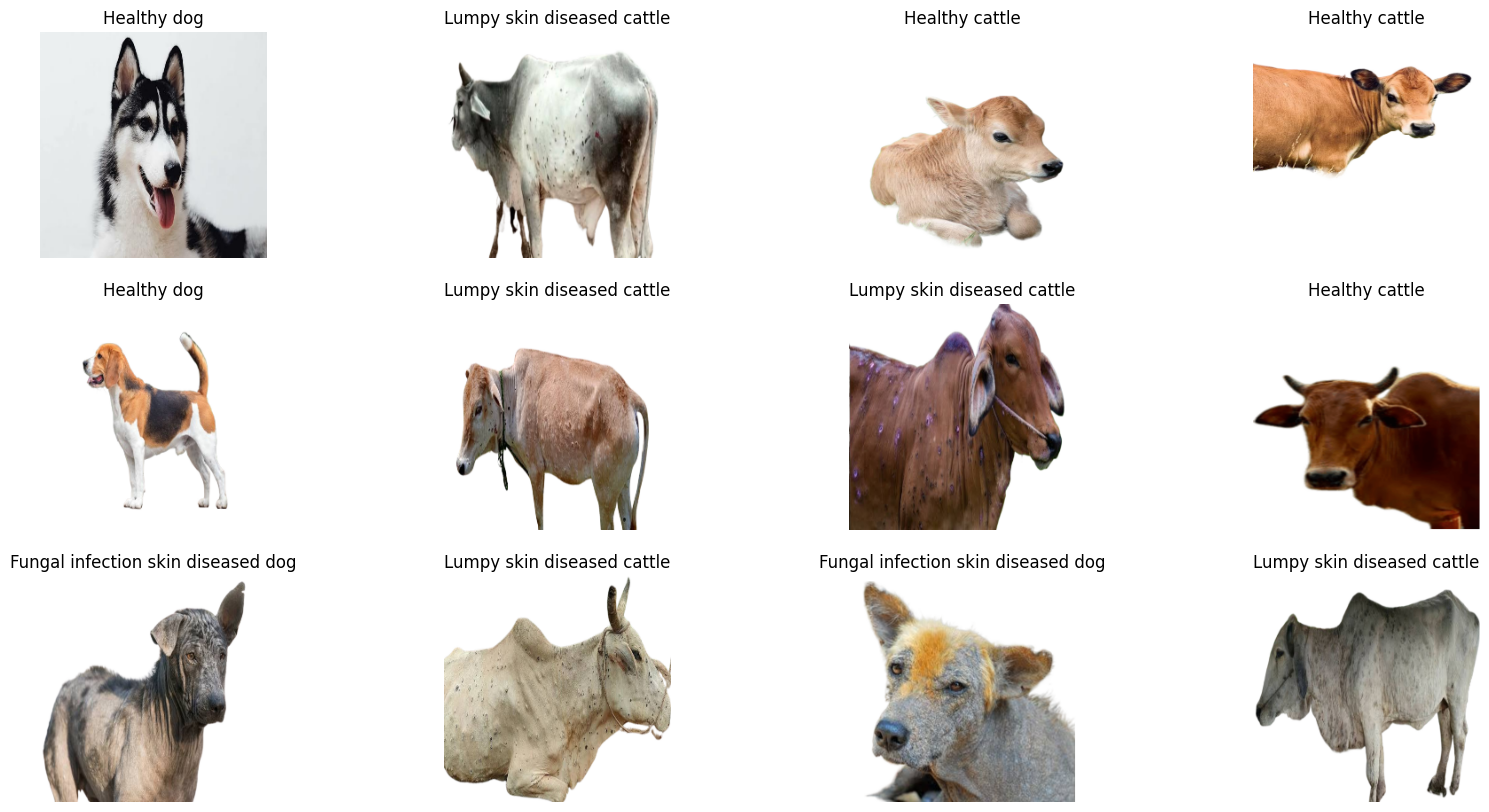

In [11]:
plt.figure(figsize=(20, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [12]:
len(dataset)

63

In [13]:
train_size = 0.8
len(dataset)*train_size

50.400000000000006

In [15]:
train_ds = dataset.take(50)
len(train_ds)

50

In [17]:
test_ds = dataset.skip(50)
len(test_ds)

13

In [18]:
val_size=0.1
len(dataset)*val_size

6.300000000000001

In [19]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [21]:
test_ds = test_ds.skip(6)
len(test_ds)

7

In [22]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [23]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [24]:
len(train_ds)

50

In [25]:
len(val_ds)

6

In [26]:
len(test_ds)

7

In [27]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [29]:

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


In [30]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [44]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [45]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

In [46]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [47]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
50/50 [==============================] - 190s 4s/step - loss: 1.3543 - accuracy: 0.3056 - val_loss: 1.5517 - val_accuracy: 0.3073
Epoch 2/30
50/50 [==============================] - 176s 4s/step - loss: 1.0064 - accuracy: 0.5550 - val_loss: 0.7780 - val_accuracy: 0.6354
Epoch 3/30
50/50 [==============================] - 171s 3s/step - loss: 0.7942 - accuracy: 0.6469 - val_loss: 0.7251 - val_accuracy: 0.6719
Epoch 4/30
50/50 [==============================] - 171s 3s/step - loss: 0.6431 - accuracy: 0.7206 - val_loss: 0.6421 - val_accuracy: 0.7604
Epoch 5/30
50/50 [==============================] - 171s 3s/step - loss: 0.5800 - accuracy: 0.7469 - val_loss: 0.6254 - val_accuracy: 0.7083
Epoch 6/30
50/50 [==============================] - 171s 3s/step - loss: 0.4851 - accuracy: 0.8081 - val_loss: 0.5390 - val_accuracy: 0.7292
Epoch 7/30
50/50 [==============================] - 171s 3s/step - loss: 0.3989 - accuracy: 0.8413 - val_loss: 0.2965 - val_accuracy: 0.8958
Epoch 8/30
50

In [48]:
scores = model.evaluate(test_ds)

7/7 [==============================] - 15s 967ms/step - loss: 0.0346 - accuracy: 0.9777


In [49]:
scores

[0.03462836146354675, 0.9776785969734192]

In [50]:
history

In [51]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 50}

In [52]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [53]:
type(history.history['loss'])

list

In [55]:
len(history.history['loss'])

30

In [56]:
history.history['loss'][:5] 

[1.354329228401184,
 1.00635826587677,
 0.7941620349884033,
 0.643108069896698,
 0.5799601078033447]

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

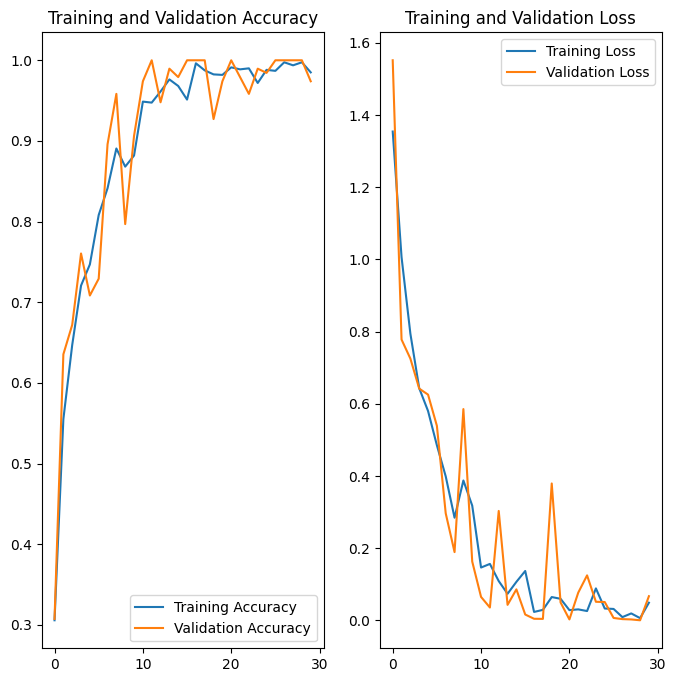

In [58]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Healthy dog
1/1 [==============================] - 1s 924ms/step
predicted label: Healthy dog


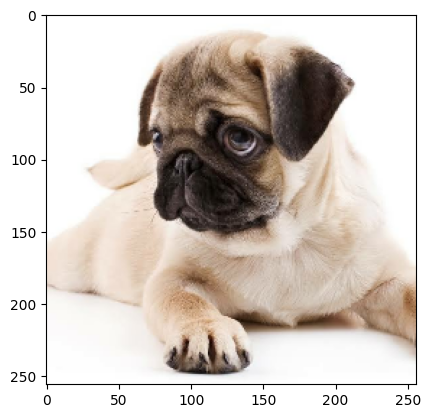

In [73]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [74]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 65ms/step


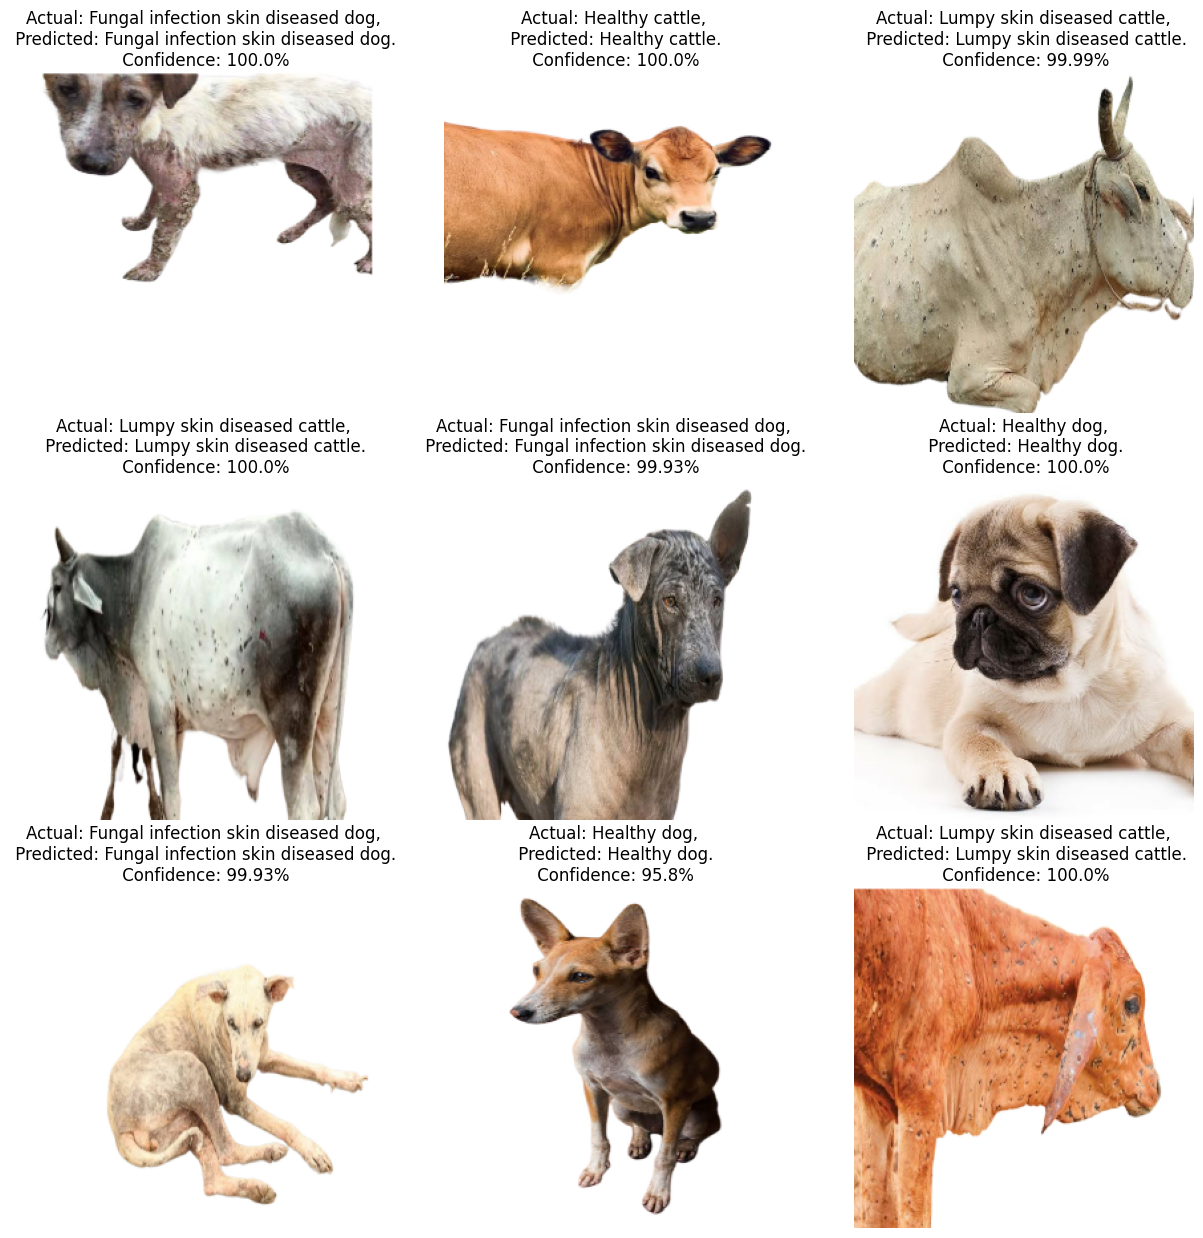

In [75]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [78]:
import os
model_version=max([int(i) for i in os.listdir("../animal diseases model") + [0]])+1
model.save(f"../animal diseases model/{model_version}")

INFO:tensorflow:Assets written to: ../animal diseases model/1\assets


INFO:tensorflow:Assets written to: ../animal diseases model/1\assets


In [80]:
model.save("../animaldiseases.h5")